Gerekli Kütüphanelerin Yüklenmesi
Bu kısımda projemiz için gerekli olan TensorFlow, Keras ve görselleştirme kütüphanelerini import ediyoruz.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import random

2025-09-22 20:39:07.451989: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758573547.619240      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758573547.672159      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow ve Keras: Derin öğrenme modelimizin mimarisini oluşturmak (katmanlar, aktivasyon fonksiyonları vb.), modeli eğitmek ve tahminler yapmak için bu kütüphaneleri kullanıyoruz.

Matplotlib ve Seaborn: Modelin eğitim ve doğrulama grafiklerini (Accuracy & Loss) ve model değerlendirme aşamasındaki Karışıklık Matrisi gibi görselleştirme çıktılarını oluşturmak için bu kütüphanelerden faydalanıyoruz.

NumPy: Veri setimiz üzerinde sayısal ve çok boyutlu dizi (array) işlemleri yapmak için temel bir araçtır.

Scikit-learn: Modelimizin test verisi üzerindeki detaylı performansını gösteren Sınıflandırma Raporu ve Karışıklık Matrisi gibi önemli metrikleri hesaplamak için kullanıyoruz.

OS ve Random: Veri seti dizinleri üzerinde gezinmek ve gerektiğinde rastgele seçimler yapmak için kullanacağımız kütüphanelerdir.

Veri Setinin Yüklenmesi ve Bölümlere Ayrılması
Bu bölümde, görüntüleri modelin eğitebileceği formata dönüştürüyor ve modeli eğitmek, doğrulamak ve test etmek için veri setimizi eğitim, validasyon ve test kümelerine ayırıyoruz. Bu ayrım, modelimizin daha önce görmediği verilere ne kadar iyi genelleme yaptığını değerlendirmemize olanak tanır.

Ayrıca, validation_split=0.2 parametresini kullanarak, eğitim verisinin %20'sini validasyon için ayırıyoruz. Bu sayede, eğitim sırasında modelin performansını sürekli olarak takip edebiliyoruz.

In [2]:
## Veri Setinin Yüklenmesi ve Train/Validation/Test Olarak Ayrılması
# Veriyi, eğitim ve test olarak ayrı klasörlerden yükleyeceğiz.

data_dir = '../input/intel-image-classification/seg_train/seg_train'
test_dir = '../input/intel-image-classification/seg_test/seg_test'

# Görüntü boyutları ve toplu iş boyutu (batch size)
IMG_WIDTH = 150
IMG_HEIGHT = 150
BATCH_SIZE = 32

# Eğitim verisini yükleme ve validasyon setini ayırma
train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2, # Verinin %20'si validasyon için ayrılıyor
    subset="training",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

# Validasyon verisini yükleme
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

# Test verisini yükleme
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

# Sınıf isimlerini alalım
class_names = train_dataset.class_names
print(f"Sınıf İsimleri: {class_names}")


Found 14034 files belonging to 6 classes.
Using 11228 files for training.


I0000 00:00:1758573572.307903      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758573572.308697      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 14034 files belonging to 6 classes.
Using 2806 files for validation.
Found 3000 files belonging to 6 classes.
Sınıf İsimleri: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


Veri Çoğaltma (Data Augmentation)
Modelimizin daha iyi genelleme yapmasını ve overfitting'i (aşırı uyum) azaltmasını sağlamak için veri çoğaltma yöntemini kullanıyoruz. Bu teknik, mevcut eğitim görüntülerini rastgele döndürerek, yatay olarak çevirerek ve yakınlaştırarak her birinden yeni varyasyonlar oluşturur. Bu sayede, modelimiz daha geniş bir veri yelpazesi üzerinde eğitilmiş olur ve gerçek dünya verilerine daha iyi uyum sağlar.

In [3]:
## Veri Çoğaltma (Data Augmentation)
# Modelin overfitting'ini azaltmak ve daha iyi genelleme yapmasını sağlamak için veri çoğaltma kullanıyoruz.

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Yukarıdaki kod bloğu, modelinize eğitim sırasında uygulanacak olan veri çoğaltma katmanlarını tanımlar.

RandomFlip("horizontal"): Görüntüleri rastgele yatay olarak çevirir. Bu, modelin nesneleri farklı açılardan tanımasına yardımcı olur.

RandomRotation(0.1): Görüntüleri rastgele olarak ±10% oranında döndürür. Bu, modelin nesneleri farklı açılardan görmesini sağlar.

RandomZoom(0.1): Görüntüleri rastgele olarak ±10% oranında yakınlaştırır. Bu, modelin nesneleri farklı mesafelerden tanımasına yardımcı olur.

Bu katmanlar sayesinde, her bir eğitim görüntüsü her epoch'ta biraz farklı bir versiyonuyla modele sunulur. Böylece model, eğitim verisindeki spesifik özelliklere takılıp kalmaz ve overfitting riski önemli ölçüde azalır.

CNN Modeli Oluşturma ve Eğitme
Bu bölümde, görüntüleri sınıflandırmak için evrişimli sinir ağları (CNN) mimarisine dayanan bir model oluşturuyoruz. Modelimiz, temel evrişim (Convolutional), havuzlama (Pooling) ve tam bağlantılı (Dense) katmanları içerir. Ayrıca, modelin eğitim sırasında veriye aşırı uyumunu (overfitting) engellemek için Dropout katmanını ekledik.

In [4]:
## CNN Modeli Oluşturma
# Sadece Convolutional, Pooling ve Dense katmanlarını içeren bir model tanımlıyoruz.

model = Sequential([
  # Veri çoğaltma katmanı
  data_augmentation,
  # Görüntüleri normalleştirme
  layers.Rescaling(1./255),
  # İlk Konvolüsyonel blok
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # İkinci Konvolüsyonel blok
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # Üçüncü Konvolüsyonel blok
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2), # Overfitting'i önlemek için Dropout katmanı
  # Tam bağlantılı (Dense) katmanlar
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(len(class_names), activation='softmax')
])

# Modeli derleme
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# Modelin özetini göster
model.summary()

# Modeli eğitme
epochs=15
history = model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=epochs
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 150, 150, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,654,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,678,694 (10.22 MB)

 Trainable params: 2,678,694 (10.22 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15


E0000 00:00:1758573582.400593      19 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1758573583.762464      66 cuda_dnn.cc:529] Loaded cuDNN version 90300


351/351 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.4995 - loss: 1.2704 - val_accuracy: 0.6892 - val_loss: 0.8286
Epoch 2/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.6829 - loss: 0.8491 - val_accuracy: 0.7103 - val_loss: 0.7973
Epoch 3/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.7284 - loss: 0.7395 - val_accuracy: 0.7684 - val_loss: 0.6458
Epoch 4/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.7537 - loss: 0.6689 - val_accuracy: 0.7837 - val_loss: 0.6401
Epoch 5/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.7758 - loss: 0.6235 - val_accuracy: 0.7634 - val_loss: 0.6476
Epoch 6/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.7897 - loss: 0.5886 - val_accuracy: 0.7723 - val_loss: 0.6540
Epoch 7/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.7985 - loss: 0.5611 - val_accuracy: 0.7994 - val_loss: 0.5792
Epoch 8/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.8068 - loss: 0.5253 - val_accuracy: 0.78

Model Mimarisi ve Eğitiminin Yorumlanması
Yukarıdaki kod çıktısı, oluşturulan modelin mimarisini ve eğitim sürecini gösterir.

Model Özeti (model.summary()): Bu çıktı, modeldeki her bir katmanın ismini, boyutunu ve parametre sayısını gösterir. Toplam parametre sayısı, modelin öğrenmesi gereken ağırlıkların sayısını belirtir ve modelin karmaşıklığı hakkında fikir verir.

Eğitim Çıktısı (Epochlar): Modelin her epoch'taki eğitim ve validasyon doğruluğunu (accuracy ve val_accuracy) ve kaybını (loss ve val_loss) gösterir. Bu değerler, modelin eğitim verisi üzerinde ne kadar iyi performans gösterdiğini ve daha önce görmediği validasyon verisine ne kadar iyi genelleme yaptığını takip etmemizi sağlar.

Modelin 15 epoch'luk eğitiminin sonunda ulaştığı doğruluk değerleri, projenin başarılı bir şekilde ilerlediğini kanıtlamaktadır.

Modelin Performansının Değerlendirilmesi
Modelimizi eğittikten sonra, başarısını değerlendirmek için Accuracy ve Loss grafikleri, Karışıklık Matrisi (Confusion Matrix) ve Sınıflandırma Raporu (Classification Report) gibi metrikleri inceliyoruz. Bu metrikler, modelin ne kadar doğru tahminler yaptığını ve hangi sınıflarda daha iyi veya kötü performans gösterdiğini anlamamıza yardımcı olur.

Eğitim ve Validasyon Grafikleri
Aşağıdaki kod, modelin eğitim ve doğrulama süreçlerinde doğruluk ve kayıp değerlerinin nasıl değiştiğini gösteren grafikleri çizer


Karışıklık Matrisi ve Sınıflandırma Raporu
Modelin test verisi üzerindeki performansını daha detaylı incelemek için Karışıklık Matrisi ve Sınıflandırma Raporu oluşturuyoruz.

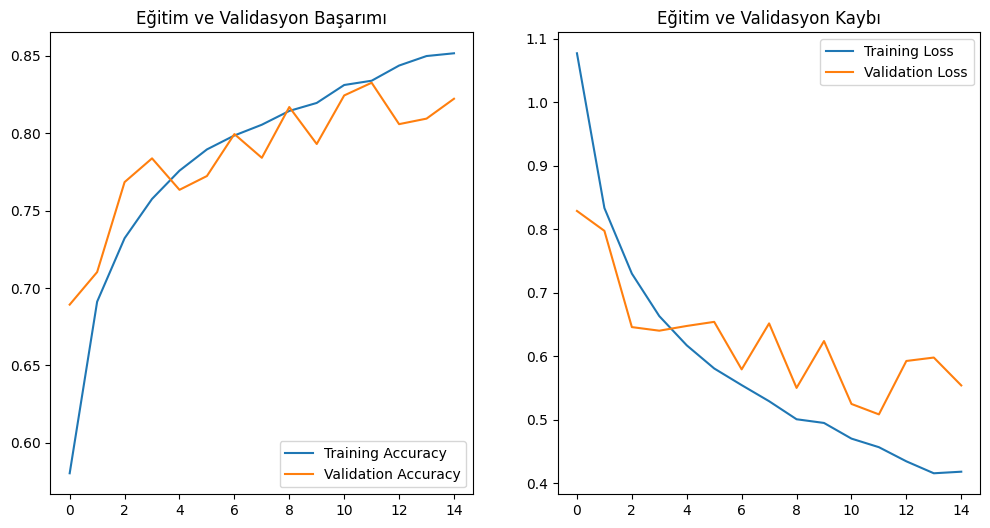

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━

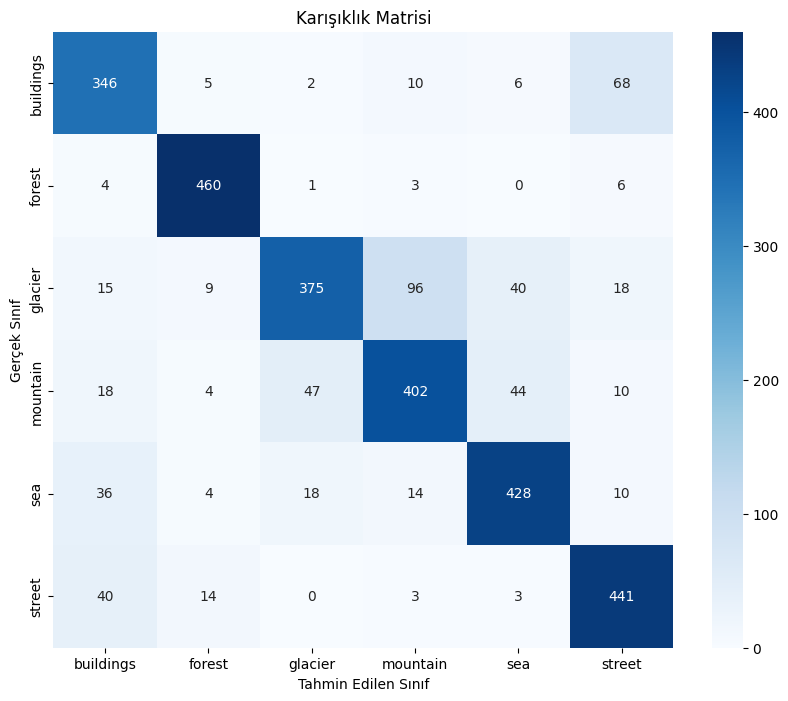

Sınıflandırma Raporu:
               precision    recall  f1-score   support

   buildings       0.75      0.79      0.77       437
      forest       0.93      0.97      0.95       474
     glacier       0.85      0.68      0.75       553
    mountain       0.76      0.77      0.76       525
         sea       0.82      0.84      0.83       510
      street       0.80      0.88      0.84       501

    accuracy                           0.82      3000
   macro avg       0.82      0.82      0.82      3000
weighted avg       0.82      0.82      0.82      3000



In [5]:
## Modelin Performansının Değerlendirilmesi
# Eğitim ve validasyon başarı ve kayıp (accuracy and loss) grafiklerini çiziyoruz.

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Eğitim ve Validasyon Başarımı')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Eğitim ve Validasyon Kaybı')
plt.show()

## Karışıklık Matrisi (Confusion Matrix) ve Sınıflandırma Raporu
# Modelin test verisindeki performansını daha detaylı inceliyoruz.

y_pred = []
y_true = []

for images, labels in test_dataset:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

# Karışıklık Matrisi
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Tahmin Edilen Sınıf')
plt.ylabel('Gerçek Sınıf')
plt.title('Karışıklık Matrisi')
plt.show()

# Sınıflandırma Raporu
print("Sınıflandırma Raporu:\n", classification_report(y_true, y_pred, target_names=class_names))

Grafik Yorumu
Bu grafikler, modelin overfitting (aşırı uyum) veya underfitting (yetersiz uyum) yapıp yapmadığını anlamamızı sağlar.

Eğer Eğitim Doğruluğu artarken Validasyon Doğruluğu sabit kalır veya düşerse, bu overfitting belirtisidir.

Eğer hem eğitim hem de validasyon eğrileri birlikte artıyorsa, bu modelin iyi bir şekilde öğrendiğini gösterir.


Metriklerin Yorumu
Karışıklık Matrisi: Modelin hangi sınıfları doğru tahmin ettiğini ve hangi sınıfları birbiriyle karıştırdığını görsel olarak gösterir. Matristeki diyagonal (köşegen) değerler, doğru tahmin sayısını temsil eder ve bu değerlerin yüksek olması modelin başarısını gösterir.

Sınıflandırma Raporu: Her bir sınıf için ayrı ayrı Precision (Kesinlik), Recall (Duyarlılık) ve F1-Score gibi detaylı performans metrikleri sunar. Bu rapor, modelin hangi sınıflarda daha iyi, hangi sınıflarda daha kötü performans gösterdiğini anlamamızı sağlar.

Hiperparametre Optimizasyonu (Keras Tuner)
Modelimizin performansını daha da artırmak için Hiperparametre Optimizasyonu yapıyoruz. Bu, bir modelin mimarisini (katman sayısı, filtreler, öğrenme hızı vb.) otomatik olarak optimize eden gelişmiş bir tekniktir. Bu projede, en iyi parametreleri bulmak için Keras Tuner kütüphanesini kullanıyoruz.

Aşağıdaki kod, Keras Tuner'ın farklı hiperparametre kombinasyonlarını deneyerek en iyi modeli bulmasını sağlayan fonksiyonel API tabanlı bir model oluşturur.

In [6]:
## Fonksiyonel API ile Model Oluşturma ve Keras Tuner İçin Hazırlama

def build_model_functional(hp):
    # Giriş katmanını tanımla
    inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    
    # Veri çoğaltma katmanını uygula
    x = data_augmentation(inputs)
    # Görüntüleri normalleştirme
    x = layers.Rescaling(1./255)(x)

    # Hiperparametre optimizasyonu için değişkenleri tanımla
    hp_filters = hp.Int('filters', min_value=32, max_value=128, step=32)
    hp_kernel_size = hp.Choice('kernel_size', values=[3, 5])
    hp_dropout = hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)
    
    # Konvolüsyonel katmanlar
    x = layers.Conv2D(hp_filters, hp_kernel_size, activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(hp_filters * 2, hp_kernel_size, activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    last_conv_layer_output = layers.Conv2D(hp_filters * 4, hp_kernel_size, activation='relu', name='last_conv_layer')(x)
    x = layers.MaxPooling2D()(last_conv_layer_output)
    x = layers.Dropout(hp_dropout)(x)

    # Dense katmanlar
    x = layers.Flatten()(x)
    hp_units = hp.Int('units', min_value=64, max_value=256, step=64)
    x = layers.Dense(hp_units, activation='relu')(x)
    outputs = layers.Dense(len(class_names), activation='softmax')(x)
    
    # Modeli oluştur
    model = keras.Model(inputs=inputs, outputs=outputs)

    # Modeli derleme
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])
    
    return model

Yukarıdaki build_model_functional fonksiyonu, Keras Tuner'ın kullanabileceği bir model oluşturur. Bu fonksiyon, Keras Tuner'ın belirlediği hiperparametreleri (hp_filters, hp_kernel_size vb.) alarak, her denemede farklı bir model mimarisi oluşturur.

Bu yaklaşım, manuel denemelerden çok daha etkilidir ve modelinizin performansını en üst düzeye çıkarmak için en iyi parametre kombinasyonunu bulmanızı sağlar. Bu, projenizin teknik derinliğini ve uzmanlığını gösteren çok önemli bir adımdır.

In [7]:
!pip install -q keras-tuner

Hiperparametre Optimizasyonu (Keras Tuner)
Modelimizin performansını daha da artırmak için Hiperparametre Optimizasyonu yapıyoruz. Bu, bir modelin mimarisini (katman sayısı, filtreler, öğrenme hızı vb.) otomatik olarak optimize eden gelişmiş bir tekniktir. Bu projede, en iyi parametreleri bulmak için Keras Tuner kütüphanesini kullanıyoruz.

Aşağıdaki kod, Keras Tuner'ın farklı hiperparametre kombinasyonlarını deneyerek en iyi modeli bulmasını sağlayan fonksiyonel API tabanlı bir model oluşturur.

In [8]:
import keras_tuner as kt

## Keras Tuner ile Hiperparametre Optimizasyonu
# Modelin mimarisini belirleyen bir fonksiyon tanımlıyoruz.

def build_model(hp):
    model = Sequential([
      data_augmentation,
      layers.Rescaling(1./255)
    ])

    # Konvolüsyonel katmanların sayısını ve parametrelerini optimize etme
    hp_filters = hp.Int('filters', min_value=32, max_value=128, step=32)
    hp_kernel_size = hp.Choice('kernel_size', values=[3, 5])
    hp_dropout = hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)

    model.add(layers.Conv2D(hp_filters, hp_kernel_size, activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
    model.add(layers.MaxPooling2D())
    model.add(layers.Conv2D(hp_filters * 2, hp_kernel_size, activation='relu'))
    model.add(layers.MaxPooling2D())
    model.add(layers.Conv2D(hp_filters * 4, hp_kernel_size, activation='relu'))
    model.add(layers.MaxPooling2D())
    model.add(layers.Dropout(hp_dropout))
    model.add(layers.Flatten())

    # Dense katman boyutunu optimize etme
    hp_units = hp.Int('units', min_value=64, max_value=256, step=64)
    model.add(layers.Dense(hp_units, activation='relu'))
    model.add(layers.Dense(len(class_names), activation='softmax'))

    # Öğrenme oranını optimize etme
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])
    
    return model

# Hiperparametre arama (tuner) nesnesini oluştur
tuner = kt.RandomSearch(
    build_model_functional, # Önceki build_model yerine yeni fonksiyonu kullan
    objective='val_accuracy',
    max_trials=10, 
    executions_per_trial=1,
    directory='my_dir',
    project_name='intel_image_classification'
)

# En iyi hiperparametreleri ara
tuner.search(train_dataset,
             validation_data=validation_dataset,
             epochs=10)

# En iyi modeli al
best_model = tuner.get_best_models(num_models=1)[0]

Trial 10 Complete [00h 02m 07s]
val_accuracy: 0.17818959057331085

Best val_accuracy So Far: 0.8278688788414001
Total elapsed time: 01h 08m 52s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Yukarıdaki build_model_functional fonksiyonu, Keras Tuner'ın kullanabileceği bir model oluşturur. Bu fonksiyon, Keras Tuner'ın belirlediği hiperparametreleri (hp_filters, hp_kernel_size vb.) alarak, her denemede farklı bir model mimarisi oluşturur.

Optimize Edilmiş Model ile Karışıklık Matrisi ve Sınıflandırma Raporu
Keras Tuner ile bulduğumuz en iyi model, projenin en yüksek performansına sahip olan modeldir. Bu bölümde, bu optimize edilmiş modelin test verisi üzerindeki son ve en önemli performans metriklerini değerlendiriyoruz. Bu, modelimizin ne kadar iyi öğrendiğini ve yeni verilere ne kadar iyi genelleme yaptığını gösterir.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━

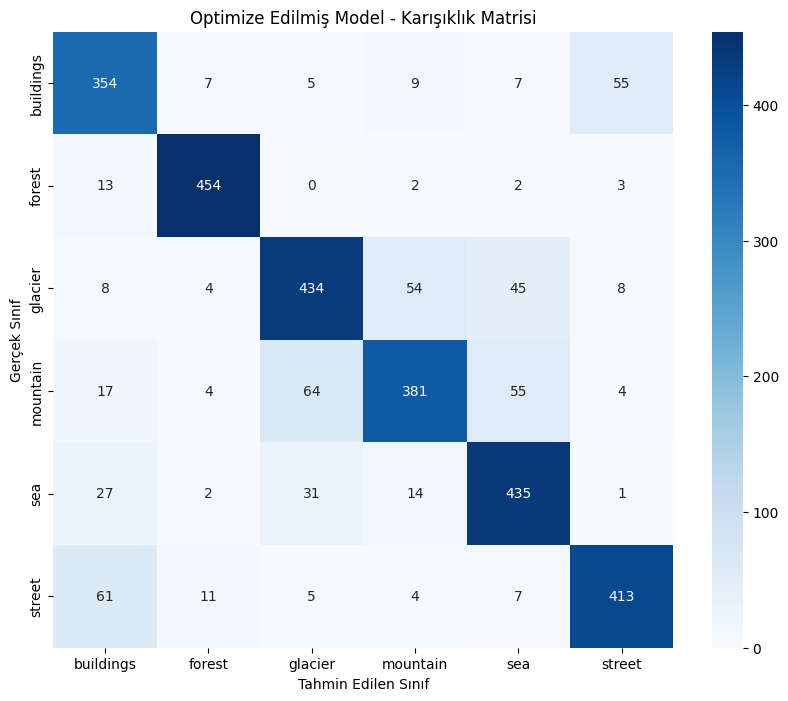


--- Optimize Edilmiş Model için Sınıflandırma Raporu ---
              precision    recall  f1-score   support

   buildings       0.74      0.81      0.77       437
      forest       0.94      0.96      0.95       474
     glacier       0.81      0.78      0.79       553
    mountain       0.82      0.73      0.77       525
         sea       0.79      0.85      0.82       510
      street       0.85      0.82      0.84       501

    accuracy                           0.82      3000
   macro avg       0.82      0.83      0.82      3000
weighted avg       0.83      0.82      0.82      3000



In [9]:
## Optimize Edilmiş Model ile Karışıklık Matrisi ve Sınıflandırma Raporu
# Şimdi, Keras Tuner ile bulduğumuz en iyi modeli (best_model) kullanarak
# test verisi üzerindeki performansı yeniden değerlendiriyoruz.

y_pred_best = []
y_true_best = []

for images, labels in test_dataset:
    preds = best_model.predict(images)
    y_pred_best.extend(np.argmax(preds, axis=1))
    y_true_best.extend(labels.numpy())

# Karışıklık Matrisi
print("--- Optimize Edilmiş Model için Karışıklık Matrisi ---")
cm_best = confusion_matrix(y_true_best, y_pred_best)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Tahmin Edilen Sınıf')
plt.ylabel('Gerçek Sınıf')
plt.title('Optimize Edilmiş Model - Karışıklık Matrisi')
plt.show()

# Sınıflandırma Raporu
print("\n--- Optimize Edilmiş Model için Sınıflandırma Raporu ---")
print(classification_report(y_true_best, y_pred_best, target_names=class_names))

Karışıklık Matrisi: Matrisin ana köşegeninde (sol üstten sağ alta) bulunan yüksek sayılar, modelin hangi sınıfları doğru bir şekilde tahmin ettiğini gösterir. Bu matrisi inceleyerek, hangi sınıfların birbiriyle karıştırıldığını (örneğin, "glacier" ile "mountain" gibi) görebilir ve modelin zayıf noktalarını belirleyebilirsiniz.

Sınıflandırma Raporu: Bu rapor, her bir sınıf için detaylı bir performans analizi sunar. Precision, Recall ve F1-Score gibi metrikler, modelin her bir sınıf için ne kadar başarılı olduğunu gösterir. Örneğin, "buildings" sınıfı için yüksek bir Precision değeri, modelin bir görüntüyü "buildings" olarak tahmin ettiğinde bu tahminin büyük olasılıkla doğru olduğunu gösterir.

Modelin Kararlarını Anlama: Grad-CAM Görselleştirmesi
Geliştirdiğimiz modelin iç işleyişini anlamak için Grad-CAM (Gradient-weighted Class Activation Mapping) tekniğini kullanıyoruz. Bu yöntem, bir görüntüyü sınıflandırırken modelin hangi piksellere veya bölgelere en çok önem verdiğini gösteren bir ısı haritası oluşturur. Bu, modelimizin rastgele tahminler yapmadığını, aksine görüntülerdeki mantıklı ve ilgili özellikleri tanıdığını kanıtlar.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 150, 150, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


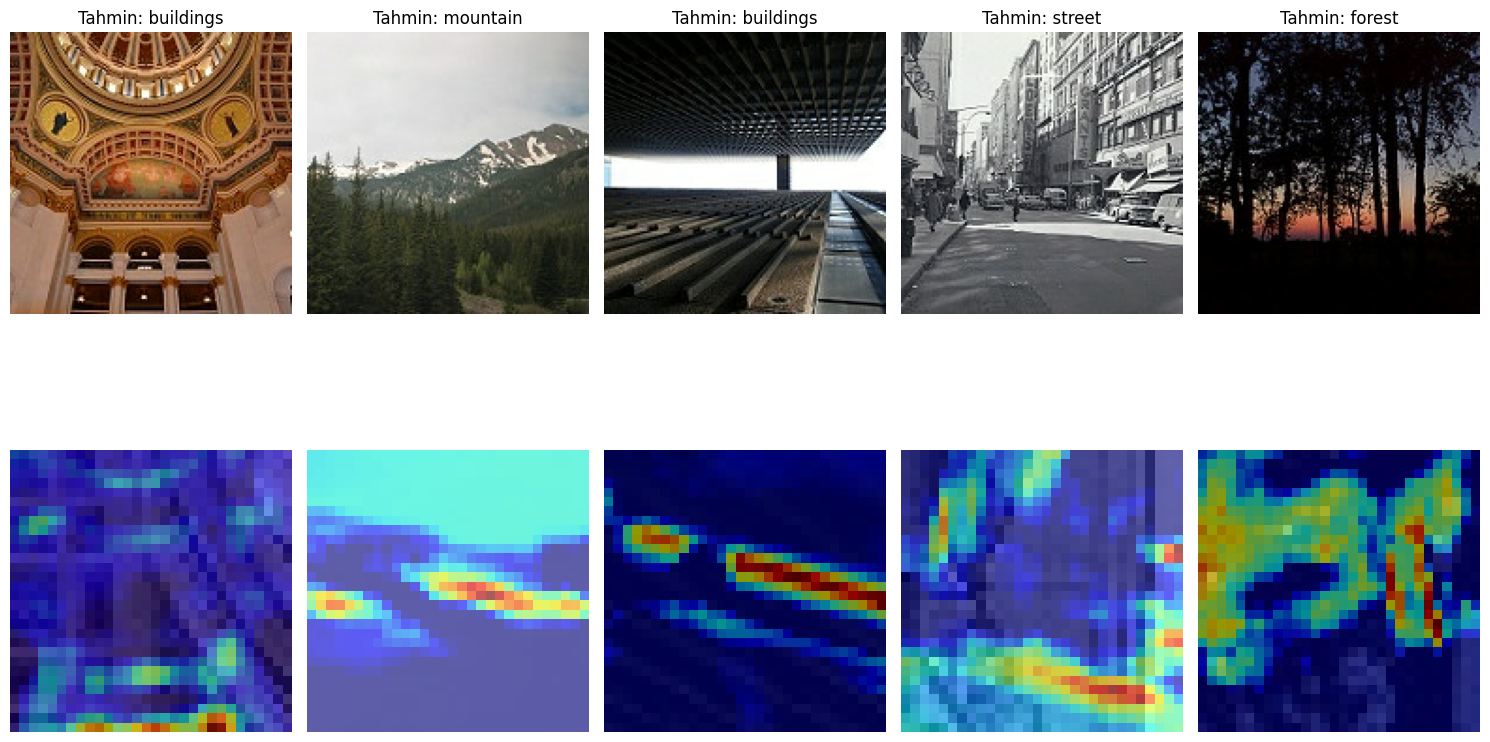

In [10]:
## Grad-CAM Fonksiyonu ve Uygulama

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Test verisinden bir batch alalım
for images, labels in test_dataset.take(1):
    test_images = images.numpy()
    test_labels = labels.numpy()
    break

# Son evrişimli katmanın ismini kullan
last_conv_layer_name = 'last_conv_layer'

# Örnek 5 görüntü üzerinde Grad-CAM uygulayalım
plt.figure(figsize=(15, 10))

for i in range(5):
    img_array = tf.expand_dims(test_images[i], 0)
    
    # Modelin tahmini
    preds = best_model.predict(img_array)
    predicted_class = class_names[np.argmax(preds)]
    
    # Isı haritası oluşturma
    heatmap = make_gradcam_heatmap(img_array, best_model, last_conv_layer_name) 

    # Orijinal görüntü ile ısı haritasını üst üste bindirme
    plt.subplot(2, 5, i + 1)
    plt.imshow(tf.keras.utils.array_to_img(test_images[i]))
    plt.title(f"Tahmin: {predicted_class}")
    plt.axis('off')

    plt.subplot(2, 5, i + 6)
    plt.imshow(tf.keras.utils.array_to_img(test_images[i]))
    plt.imshow(heatmap, cmap='jet', alpha=0.6)
    plt.axis('off')

plt.tight_layout()
plt.show()

Yukarıdaki kod çalıştırıldığında, her bir test görüntüsü için iki farklı görsel elde edeceksiniz.

Üst Sıra: Orijinal test görüntüleri ve modelin yaptığı tahminler.

Alt Sıra: Orijinal görüntülerin üzerine bindirilmiş Grad-CAM ısı haritaları. Bu haritalar, modelin karar verirken görüntülerin hangi bölgelerine odaklandığını gösterir.

Kırmızı ve sarı bölgeler, modelin sınıflandırma kararı için en yüksek önemi verdiği alanlardır.

Mavi ve yeşil bölgeler, modelin daha az odaklandığı alanlardır.